Max draw down of soft payouts: 24.94915091092146
% of positive clv: 0.5217391304347826
count    414.000000
mean       0.051797
std        0.343212
min       -0.730120
25%       -0.163829
50%        0.023562
75%        0.257451
max        1.215909
dtype: float64
Expected/Actual wins: 95.16093056799309/99
Win percentage: 0.2391304347826087


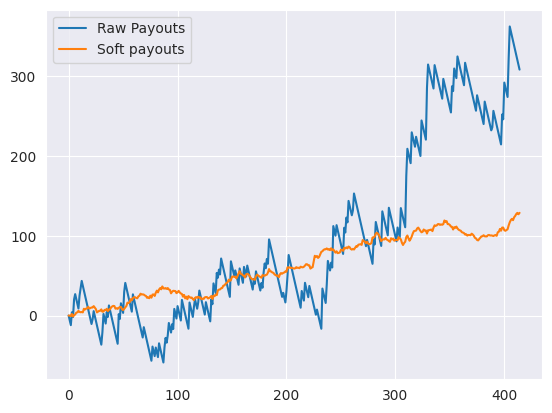

In [1]:
from util.stats_calculator import get_max_draw_down
from typing import List
from util.plot import plot_wealth_growth
import pandas as pd
from Model.Betting.evaluate import get_payout, LiveResult
import csv

def row_to_live_result(row: List[str]) -> LiveResult:
    return LiveResult(float(row[0]), float(row[1]), row[3]=="True", stakes=float(row[2]))

with open('live_results.csv', newline='') as csvfile:
    live_result_reader = csv.reader(csvfile, delimiter=' ', quotechar='|')
    
    live_results = [row_to_live_result(row) for row in live_result_reader]

clvs = [result.clv for result in live_results]
soft_payouts = [result.clv * result.stakes for result in live_results]
print(f"Max draw down of soft payouts: {get_max_draw_down(soft_payouts)}")
positive_clv_percentage = len([1 for payout in soft_payouts if payout > 0]) / len(soft_payouts)
print(f"% of positive clv: {positive_clv_percentage}")

payouts = [get_payout(result, result.stakes) for result in live_results]
print(pd.Series(clvs).describe())

expected_wins = sum([1 / live_result.starting_odds for live_result in live_results])
n_wins = sum([1 for live_result in live_results if live_result.has_won])
print(f"Expected/Actual wins: {expected_wins}/{n_wins}")
print(f"Win percentage: {n_wins / len(live_results)}")

plot_wealth_growth(payouts, label="Raw Payouts")
plot_wealth_growth(soft_payouts, label="Soft payouts")

160.0
160.48
162.277376
162.84210126847998
161.64358340314396
160.19525689585183
158.913694840685
159.21245258698548
162.46675511786347
156.55296523157324
156.44650921521577
161.80949555111337
162.23020023954626
162.7493368803128
162.44336812697782
164.76955715855613
166.06794126896554
166.67907129283535
166.69240561853877
170.039589123359
163.76852907648953
174.30212086668934
174.44156256338266
176.57672728915847
197.2008890365322
200.87671360817316
194.2317119220148
193.74224800797134
Lowest bankroll: 39111.62730380394


<AxesSubplot:>

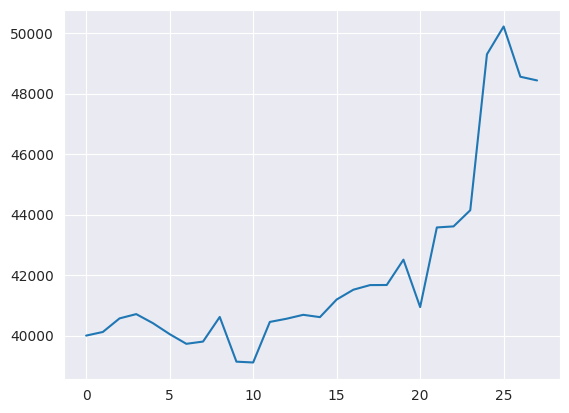

In [29]:
import csv
from util.plot import plot_wealth_growth
import seaborn as sns

STAKING_FRACTION = 0.004
bankroll = 40000
bankroll_snapshots = []

current_staking_size = max(STAKING_FRACTION * bankroll, 6)

with open('live_results.csv', newline='') as csvfile:
    live_result_reader = csv.reader(csvfile, delimiter=' ', quotechar='|')
    
    profit_of_day = 0
    for row in live_result_reader:
        is_new_day = int(row[4]) == 1
        
        if is_new_day:
            bankroll += profit_of_day
            bankroll_snapshots.append(bankroll)
            profit_of_day = 0
            current_staking_size = max(STAKING_FRACTION * bankroll, 6)
            print(current_staking_size)
        
        offer_odds = float(row[0])
        has_won = row[3]=="True"
        
        profit_of_day -= current_staking_size
        if has_won:
            profit_of_day += offer_odds * current_staking_size

print(f"Lowest bankroll: {min(bankroll_snapshots)}")
sns.lineplot(bankroll_snapshots)

PearsonRResult(statistic=0.025133271463483254, pvalue=0.6175844529328621)

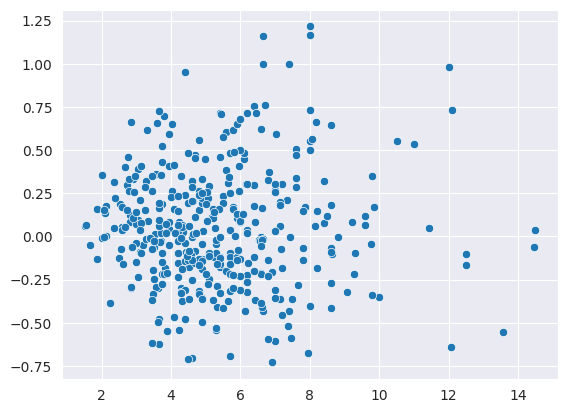

In [9]:
from scipy.stats import pearsonr
import seaborn as sns

offer_odds = [result.offer_odds for result in live_results]
sns.scatterplot(x=offer_odds, y=clvs)

pearsonr(x=offer_odds, y=clvs)